In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
path = untar_data("")
path.ls()

[PosixPath('/home/sahand/Smoke_detection/data/amazon forest green'),
 PosixPath('/home/sahand/Smoke_detection/data/smoke'),
 PosixPath('/home/sahand/Smoke_detection/data/Examples_DST3_Dataset'),
 PosixPath('/home/sahand/Smoke_detection/data/amazon forest fire'),
 PosixPath('/home/sahand/Smoke_detection/data/labels.csv'),
 PosixPath('/home/sahand/Smoke_detection/data/forest'),
 PosixPath('/home/sahand/Smoke_detection/data/Synth_Smoke_Frame_Classification'),
 PosixPath('/home/sahand/Smoke_detection/data/models'),
 PosixPath('/home/sahand/Smoke_detection/data/forest fire smoke'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation'),
 PosixPath('/home/sahand/Smoke_detection/data/TTG TUR'),
 PosixPath('/home/sahand/Smoke_detection/data/stage-2.pth'),
 PosixPath('/home/sahand/Smoke_detection/data/omdena_data')]

In [3]:
image_path = path/'TTG TUR/TTG TUR'
smoke_path = path/'smoke'
forst_smoke_path = path/'forest fire smoke'
forst_path = path/'forest'
fire_path = path/'amazon forest fire'
forest_green_path = path/'amazon forest green'
print(image_path)

image_paths = glob.glob(os.path.join(image_path,'*.jpeg'))  
forst_smoke_paths = glob.glob(os.path.join(forst_smoke_path,'*.jpg'))
forst_paths = glob.glob(os.path.join(forst_path,'*.jpg'))
fire_paths = glob.glob(os.path.join(fire_path,'*.jpg'))
forest_green_paths = glob.glob(os.path.join(forest_green_path,'*.jpg'))
smoke_paths = glob.glob(os.path.join(smoke_path,'*.jpg'))

/home/sahand/Smoke_detection/data/TTG TUR/TTG TUR


In [4]:
data = []

for image_path in image_paths:
    
    label_name = image_path.split('.jpeg')[0][-3:]
    image_path=image_path[34:]
    
    label = -1
    
    if label_name == 'SIM':
        label = 1
    elif label_name == 'NAO':
        label = 0
    
    data.append((image_path, label))

In [5]:

for smoke in smoke_paths :
    smoke= smoke[34:]

    data.append((smoke, 1))

for smoke in forst_smoke_paths :
    smoke= smoke[34:]

    data.append((smoke, 1))

for forest in forst_paths :
    forest= forest[34:]

    data.append((forest, 0))

for forest in forest_green_paths :
    forest= forest[34:]

    data.append((forest, 0))

for smoke in fire_paths :
    smoke= smoke[34:]

    data.append((smoke, 1))

In [6]:
    
labels = pd.DataFrame(data)
labels.to_csv(path/'labels.csv', index=False)

In [7]:
image_path = path/'TTG TUR/TTG TUR'

labels_path=path/'labels.csv'
labels =pd.read_csv(labels_path)

In [8]:
labels.tail(20)

,0,1
6594,amazon forest fire/12.33ecde04-amazon-rainfore...,1
6595,amazon forest fire/15.LS4MPIGE4EI6TNPEKSVFNVNX...,1
6596,amazon forest fire/8.kp3j1o5ntikbk0rh8y0m.jpg,1
6597,amazon forest fire/21.1164446768.jpg,1
6598,amazon forest fire/49.rainforest-fire-frame.jpg,1
6599,amazon forest fire/39.amazon-fires.jpg,1
6600,amazon forest fire/67.0_Tocantins-Brazil-23rd-...,1
6601,amazon forest fire/33.amazon-rainforest-fires.jpg,1
6602,amazon forest fire/56.1040.jpg,1
6603,amazon forest fire/87.Amazon_wildfires.00_01_2...,1


In [9]:
bs= 32
data = ImageList.from_df(labels, path).split_by_rand_pct().label_from_df().transform(get_transforms(), size=256).databunch(bs=bs).normalize(imagenet_stats)  


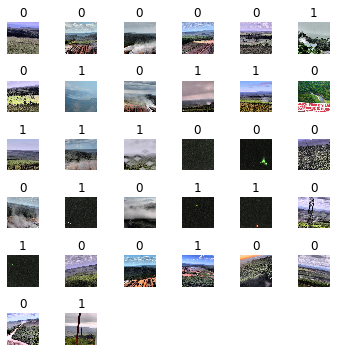

In [10]:
data.show_batch(rows=10, figsize=(5,5))


In [11]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==0) * (last_target==0)).float().sum()
        self.total += (preds==0).float().sum()
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.correct/self.total)
    
class AUROC(Callback):
    "Computes the area under the curve (AUC) score based on the receiver operator characteristic (ROC) curve. Restricted to binary classification tasks."
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = LongTensor([]), Tensor([])
        
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = F.softmax(last_output, dim=1)[:,-1]
        self.preds = torch.cat((self.preds, last_output.cpu()))
        self.targs = torch.cat((self.targs, last_target.cpu().long()))
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, auc_roc_score(self.preds, self.targs))

In [13]:

learn = cnn_learner(data, models.resnet152, metrics=[accuracy, Precision(), AUROC()], callback_fns=ShowGraph)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


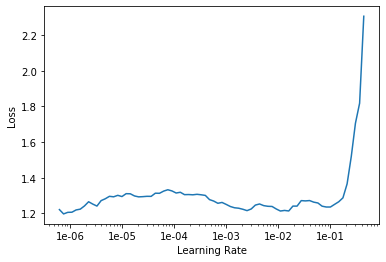

In [14]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision,auroc,time
0,1.041138,0.666498,0.701210,0.816065,0.717817,01:21
1,0.847092,0.577542,0.754160,0.818939,0.751202,01:21
2,0.710469,0.546490,0.776097,0.828893,0.788707,01:19
3,0.619454,0.608962,0.742814,0.773810,0.675487,01:20
4,0.550785,0.497890,0.755673,0.781852,0.771836,01:20
5,0.501315,0.481164,0.775340,0.788479,0.790906,01:20
6,0.496161,0.454889,0.796520,0.832836,0.821595,01:19
7,0.502313,0.447651,0.800303,0.812616,0.824291,01:21
8,0.455821,0.439843,0.804085,0.832517,0.830179,01:21
9,0.455655,0.427355,0.812405,0.835603,0.842334,01:19


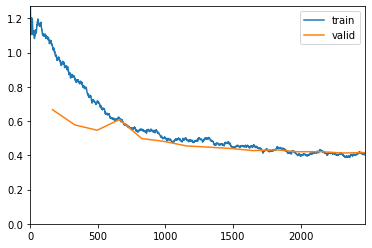

In [15]:
learn.fit_one_cycle(15,slice(1e-3))


In [16]:
learn.save('stage-resnet152')


epoch,train_loss,valid_loss,accuracy,precision,auroc,time
0,0.415471,0.413647,0.822239,0.844270,0.854053,01:20
1,0.419212,0.436532,0.803328,0.808182,0.839322,01:21
2,0.430584,0.416358,0.821483,0.845472,0.852615,01:20
3,0.410519,0.414969,0.822239,0.846989,0.852762,01:21
4,0.389595,0.411968,0.821483,0.844794,0.856296,01:22


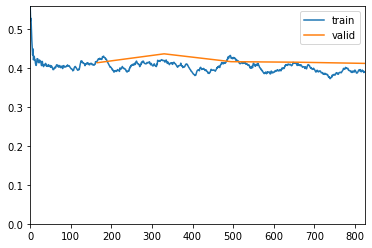

In [17]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,3e-4))


In [18]:
learn.save('stage-1-152')


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))


In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [24]:
learn.save('stage-1-50')
